In [1]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

In [4]:
# constants
A = 3e-4
use_sin = False

## First let's try to detect the helical trajectory (for the x-y plane) in a single-particle file

In [5]:
# Get all the "Hits" data files
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n1-1GeV-0.5eta')
hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_initial.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])
dfs = [pd.read_csv(os.path.join(root_dir, file)) for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [6]:
random.seed(8)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000029-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,track
0,4503599644147712,936748859932016764,16.683874,27.527729,7.455000,0.110797,0.510034,0.860154,0.231598,1.031892,0,0,0,0,0,1.0,32.188935,1.025922,"(32.18893472735766, 1.0259217315432712)"
1,4503599644147712,936748859932016778,17.186132,28.375340,7.683180,0.114188,0.509526,0.860455,0.231598,1.031892,0,0,0,0,1,1.0,33.174132,1.026217,"(33.174132070192734, 1.0262170908764479)"
2,4503599644147712,936748997370970502,34.540306,58.389202,15.712786,0.233525,0.491530,0.870861,0.231598,1.031892,0,0,0,0,2,1.0,67.840487,1.036611,"(67.84048693336703, 1.0366110277988427)"
3,4503599644147712,936749134809924310,57.039658,99.596489,26.586557,0.395131,0.466823,0.884351,0.231598,1.031892,0,0,0,0,3,1.0,114.773617,1.050687,"(114.7736170043114, 1.0506866179192182)"
4,4503599644147712,936749272248877138,81.947067,148.729919,39.344940,0.584747,0.437363,0.899285,0.231598,1.031892,0,0,0,0,4,1.0,169.811397,1.067202,"(169.81139727596994, 1.067201767998089)"


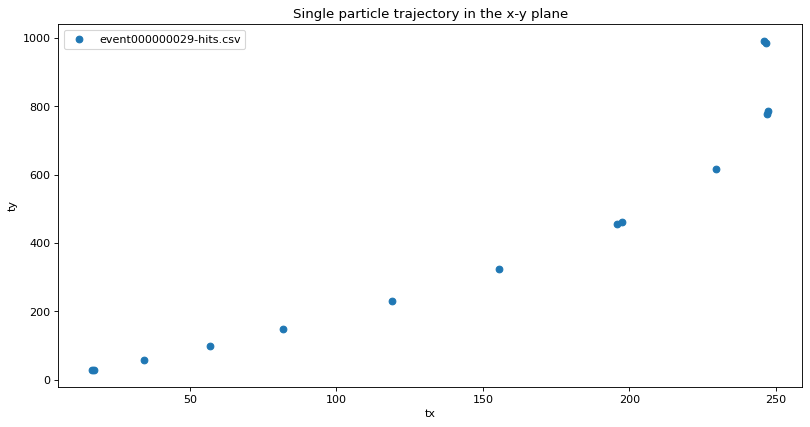

In [7]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])

plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Single particle trajectory in the x-y plane')
plt.show()

Using the formula

$$\frac{qA}{p_T} = \frac{\sin(\phi_0 - \phi_1)}{r_1}$$

By considering $q/p_T$ to be the $y$-unknown and $\phi_0$ to be the x-unknown, we get the following formula:

$$y = \frac{\sin(x - \phi)}{Ar}$$

where $r$ is the distance of an x-y point to the origin and $\phi$ is it's angle in polar coordinates.

In [8]:
all_tracks = list(df['track'])
all_tracks

[(32.18893472735766, 1.0259217315432712),
 (33.174132070192734, 1.0262170908764479),
 (67.84048693336703, 1.0366110277988427),
 (114.7736170043114, 1.0506866179192182),
 (169.81139727596994, 1.067201767998089),
 (259.79469955722175, 1.0942350145752262),
 (360.1344678548052, 1.12444801954879),
 (503.4482567288208, 1.1677805248988884),
 (497.2613217802021, 1.1659045122554774),
 (658.4002819769984, 1.2149596888725136),
 (817.5709051756802, 1.263896042355339),
 (824.5475210657866, 1.2660539695425284),
 (1015.2199316681568, 1.3255330814561601),
 (1022.2161748098042, 1.3277357365714457)]

Let's define here the bin size and the range of search in the x-axis ($\phi_0$).

In [9]:
bin_size = (0.001, 0.05)
width_limits = (0, np.pi)
x_range = np.arange(width_limits[0], width_limits[1], bin_size[0])

Let's plot the tracks in the Hough Space.

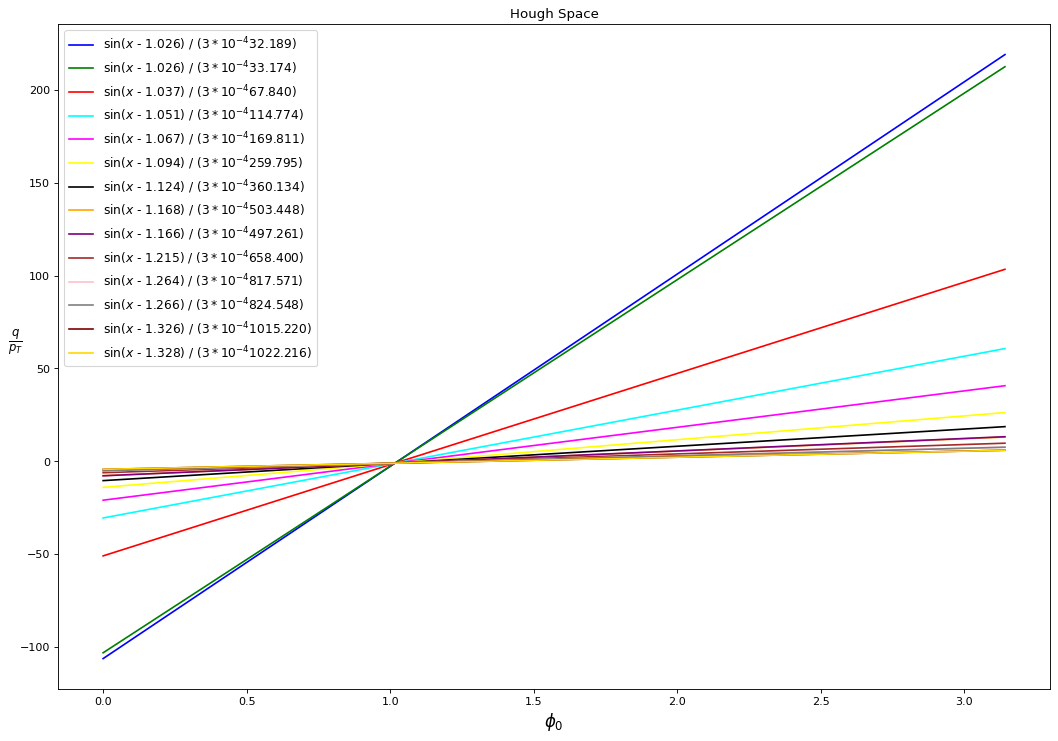

In [10]:
min_y, max_y = float('inf'), float('-inf')

plt.figure(figsize=(16, 11), dpi=80)
for idx, track in enumerate(all_tracks):
    r, phi = track
    label = '$\sin$($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    ys = np.sin(x_range - phi) / (A * r) if use_sin else (x_range - phi) / (A * r)
    min_y = min(np.min(ys), min_y)
    max_y = max(np.max(ys), max_y)
    plt.plot(x_range, ys, label=label, color=colors[idx % len(colors)])

plt.xlabel('$\phi_0$', fontsize=15)
h = plt.ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
plt.title('Hough Space')
plt.legend(loc='best', prop={'size': 11})
plt.show()

Let's run the pipeline and plot the results.

In [11]:
from notebook_utils import pipeline

height_limits = (min_y - 1, max_y + 1)
limits = (width_limits, height_limits)
selection_hyperparams = {'minimum-hits-per-bin': 10}

accumulator, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, selection_hyperparams, use_sin=use_sin)
len(est_tracks_to_hits)

2

In [12]:
accumulator.shape

(3141, 6545)

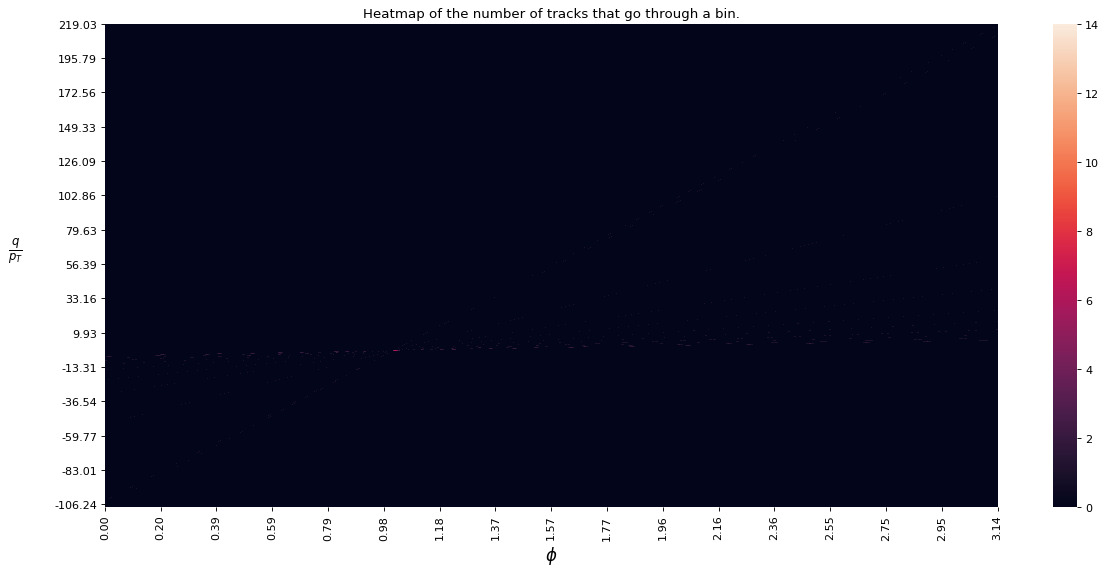

In [13]:
plt.figure(figsize=(18, 8), dpi=80)
ax = sns.heatmap(accumulator.T)
ax.set_xlabel('$\phi$', fontsize=15)

plt.locator_params(axis='x', nbins=17)
xticks = np.linspace(0.15, accumulator.shape[0], 17)
x_range = np.linspace(width_limits[0], width_limits[1], xticks.shape[0])
xtick_labels = ['{:.2f}'.format(tick) for tick in x_range]

plt.locator_params(axis='y', nbins=15)
yticks = np.linspace(35, accumulator.shape[1], 15)
y_range = np.linspace(min_y, max_y, yticks.shape[0])
ytick_labels = ['{:.2f}'.format(tick) for tick in y_range]

h = ax.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.1, 0.50)
ax.invert_yaxis()
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_title('Heatmap of the number of tracks that go through a bin.')
plt.show()

Let's cross check that the emittance angle $\phi_0$ falls in the right bin.

In [14]:
phi_est = list(est_tracks_to_hits.keys())[0][0]
phi_truth = np.arctan2(initial_df['py'], initial_df['px']).item()
print(f'Estimated phi:\t{phi_est:.3f}\nTruth phi:\t{phi_truth:.3f}')

Estimated phi:	1.015
Truth phi:	1.016


## Now let's try to detect the helical trajectory (for the x-y plane) in a multi-particle file

In [15]:
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-0.5to10GeV-0.5eta')

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])

dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
       for file in hit_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [16]:
random.seed(2021)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000051-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,track
0,4503599996469248,936748859932016652,31.950581,1.960413,10.167611,0.112050,5.853292,0.368759,1.862878,6.154550,0,0,0,0,0,1.0,32.010667,0.061281,"(32.0106673096836, 0.06128085312818037)"
1,4503600046800896,936748859932016652,31.212055,8.084858,8.601591,0.111488,1.746427,0.462362,0.481962,1.872762,0,0,0,0,0,1.0,32.242167,0.253459,"(32.24216676524436, 0.25345924255447094)"
2,4503600046800896,936748859932016666,32.001701,8.294030,8.819519,0.114312,1.746301,0.462835,0.481962,1.872762,0,0,0,0,1,1.0,33.059036,0.253595,"(33.05903551659354, 0.2535948267091365)"
3,4503599660924928,936748859932016679,-29.345648,-17.591038,-10.955899,0.119842,-7.877036,-4.733791,-2.942781,9.650265,0,0,0,0,1,1.0,34.214203,-2.601583,"(34.2142025434274, -2.601582947009528)"
4,4503599728033792,936748859932016679,-27.635937,-18.932758,1.574936,0.111876,-6.144863,-4.221881,0.350511,7.464425,0,0,0,0,1,1.0,33.499169,-2.540952,"(33.499169155855576, -2.540952158240271)"


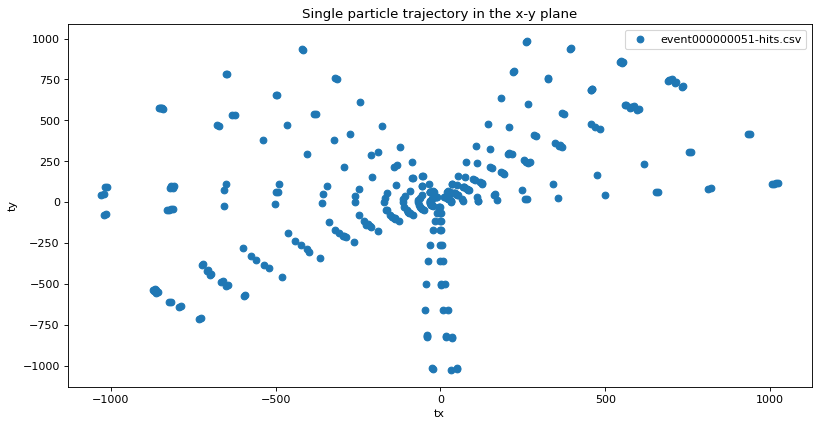

In [17]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])

plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Single particle trajectory in the x-y plane')
plt.show()

In [18]:
all_tracks = list(df['track'])
all_tracks

[(32.0106673096836, 0.06128085312818037),
 (32.24216676524436, 0.25345924255447094),
 (33.05903551659354, 0.2535948267091365),
 (34.2142025434274, -2.601582947009528),
 (33.499169155855576, -2.540952158240271),
 (32.40452724609348, -2.40286098985441),
 (33.29575279557957, -2.5208888550673),
 (32.19865528093487, -1.7205138324180145),
 (33.1530553181962, -1.7203918447563147),
 (32.26761594443146, -1.5899952939467141),
 (32.521741539725284, 0.718521496720264),
 (32.180458229315974, 0.7870879122044964),
 (31.974284154245147, 0.9396852328640297),
 (32.40510490644654, 0.7386275412777029),
 (31.991144349772515, 1.250884959108813),
 (32.4632314973116, 1.121005988738219),
 (34.122331192624266, 0.9398075448390047),
 (31.970141399493738, 2.0532292238932084),
 (32.632086220976575, 1.8795149670059774),
 (31.980079849683932, 2.0442910620584596),
 (31.957483313861346, 2.48735416131413),
 (32.141844371114665, 2.761172520484157),
 (32.181258298506364, 2.9874179018296854),
 (32.18154876769458, -2.902979

Let's define here the bin size and the range of search in the x-axis ($\phi_0$).

In [19]:
bin_size = (0.005, 0.05)
width_limits = (0, np.pi)
x_range = np.arange(width_limits[0], width_limits[1], bin_size[0])

Let's plot the tracks in the Hough Space.

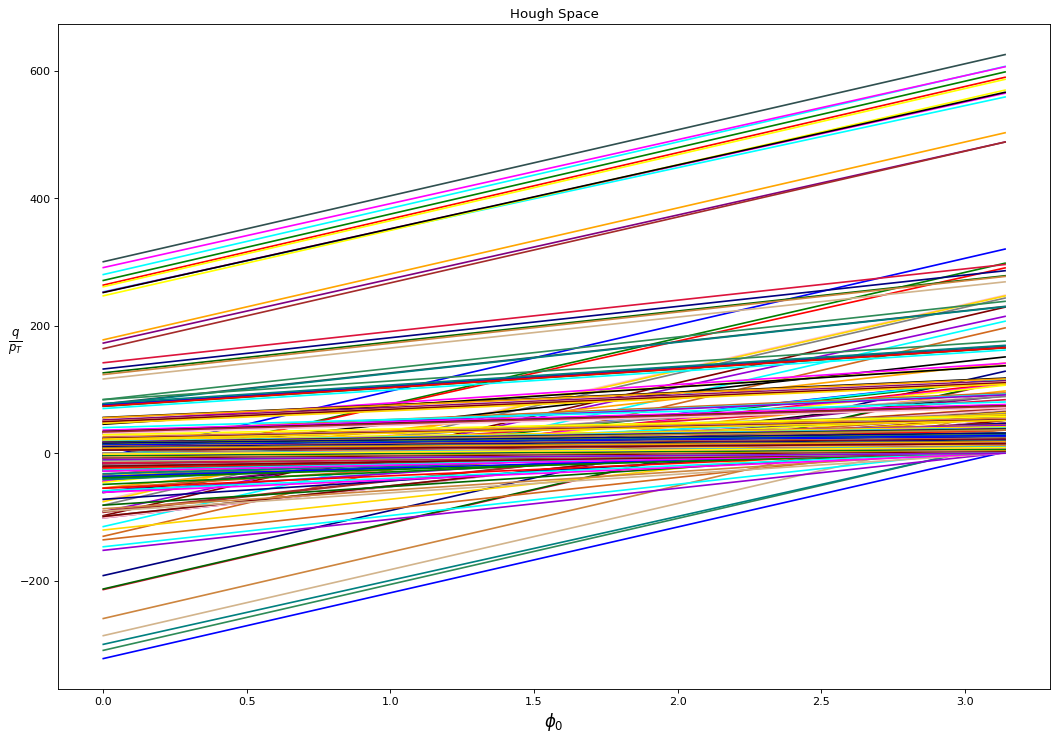

In [20]:
min_y, max_y = float('inf'), float('-inf')

plt.figure(figsize=(16, 11), dpi=80)
for idx, track in enumerate(all_tracks):
    r, phi = track
    label = '$\sin$($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    ys = np.sin(x_range - phi) / (A * r) if use_sin else (x_range - phi) / (A * r)
    min_y = min(np.min(ys), min_y)
    max_y = max(np.max(ys), max_y)
    plt.plot(x_range, ys, color=colors[idx % len(colors)])

plt.xlabel('$\phi_0$', fontsize=15)
h = plt.ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
plt.title('Hough Space')
plt.show()

Let's run the pipeline and plot the results.

In [21]:
from notebook_utils import pipeline

height_limits = (min_y - 1, max_y + 1)
limits = (width_limits, height_limits)
selection_hyperparams = {'minimum-hits-per-bin': 10}

accumulator, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, selection_hyperparams, use_sin=use_sin)
len(est_tracks_to_hits)

15

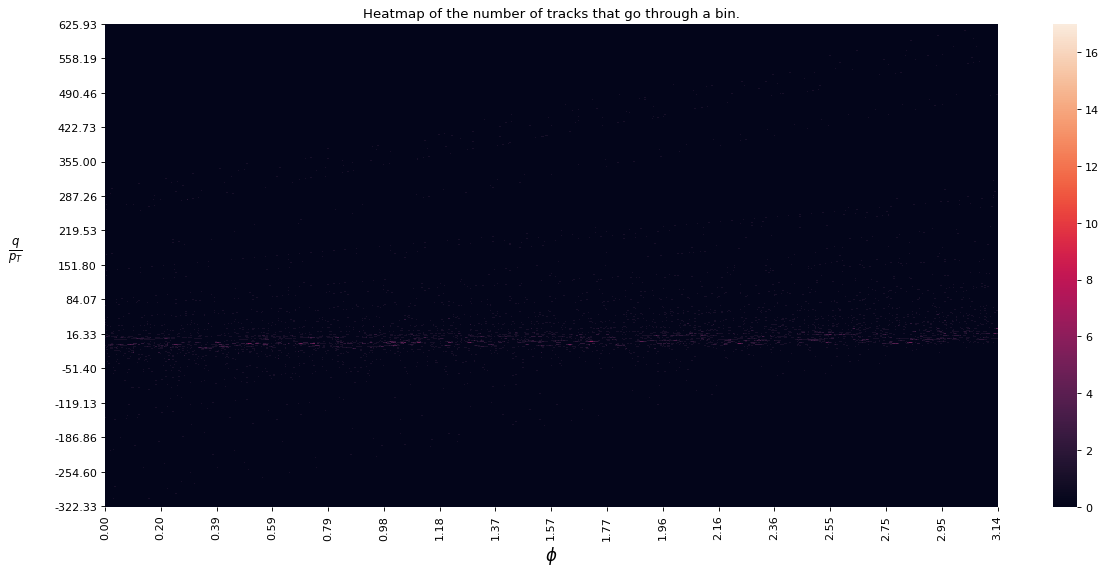

In [22]:
plt.figure(figsize=(18, 8), dpi=80)
ax = sns.heatmap(accumulator.T)
ax.set_xlabel('$\phi$', fontsize=15)

plt.locator_params(axis='x', nbins=17)
xticks = np.linspace(0.15, accumulator.shape[0], 17)
x_range = np.linspace(width_limits[0], width_limits[1], xticks.shape[0])
xtick_labels = ['{:.2f}'.format(tick) for tick in x_range]

plt.locator_params(axis='y', nbins=15)
yticks = np.linspace(35, accumulator.shape[1], 15)
y_range = np.linspace(min_y, max_y, yticks.shape[0])
ytick_labels = ['{:.2f}'.format(tick) for tick in y_range]

h = ax.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.1, 0.50)
ax.invert_yaxis()
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_title('Heatmap of the number of tracks that go through a bin.')
plt.show()